In [1]:
from astropy.io import fits

In [2]:
hdu = fits.open('cpt1m013-fa14-20210412-0125-e91.fits.fz')

In [3]:
psf_hdu = fits.open('psf-new.fits')

In [4]:
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode(connected=True)

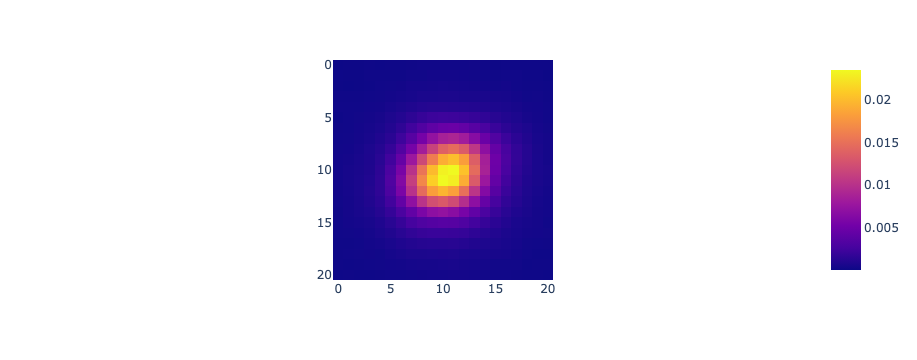

In [5]:
psf_plot = px.imshow(psf_hdu[0].data, aspect='equal')
psf_plot.show()

In [6]:
from psf_wrench import PSFSplineModel

In [64]:
m = PSFSplineModel(hdu['SCI'].data, stamp_size=20, oversampling=10, spline_order=2, alignment_order=1)
m.fit(smoothing=0,  detect_sigma=10)

In [36]:
x_center, y_center = 2193, 2140
half_width=15
cutout_slice = slice(y_center - half_width, y_center + half_width), slice(x_center - half_width, x_center + half_width)
star_cutout = hdu['SCI'].data[cutout_slice]
star_cutout -= np.median(star_cutout)
cutout_error = hdu['ERR'].data[cutout_slice]

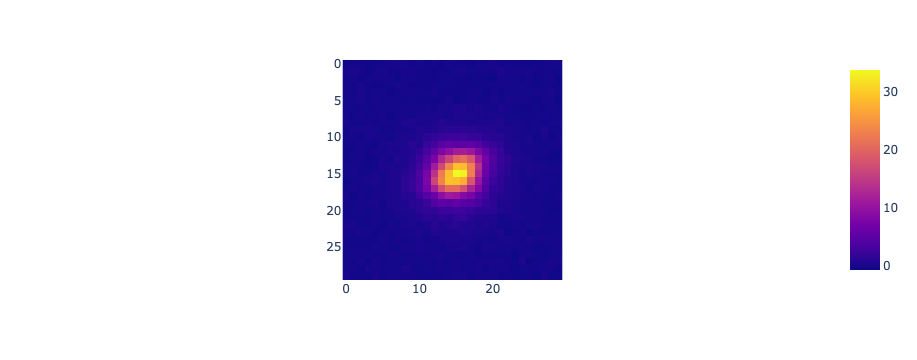

In [37]:
cutout_plot = px.imshow(star_cutout, aspect='equal')
cutout_plot.show()

In [38]:
hdu['SCI'].data[y_center, x_center]

33.68637

In [39]:
star_cutout[half_width, half_width]

33.68637

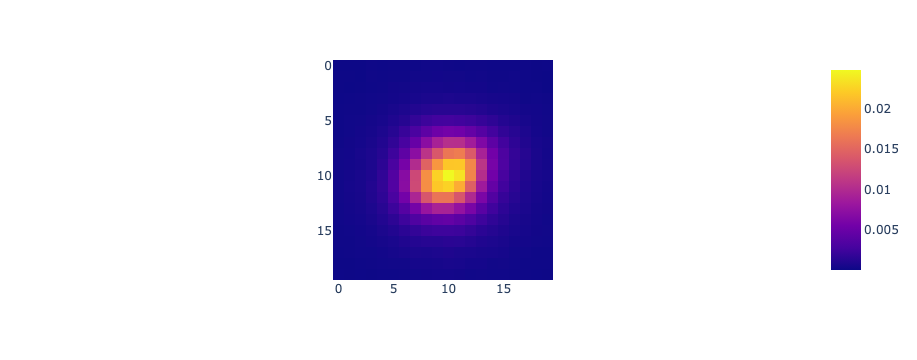

In [40]:
px.imshow(m.evaluate(x_center, y_center, oversampled=False), aspect='equal').show()

In [125]:
from scipy.ndimage import zoom
def model(params, oversampled_psf_model, oversampling_factor, output_shape):
    x0, y0, flux = params
    psf = np.zeros(output_shape)
    # This only works for even square, cutout sizes 
    cutout_half_width = psf.shape[0] // 2
    
    oversampled_psf = np.zeros(oversampled_psf_model.shape)
    x0 = int(np.round(x0 * oversampling_factor))
    if x0 < 0:
        x_model_slice = slice(x0, None, None)
        x_slice = slice(0, -x0, None)
    elif x0 == 0:
        x_model_slice = slice(None, None, None)
        x_slice = slice(None, None, None)
    else:
        x_model_slice = slice(0, -x0, None)
        x_slice = slice(x0, None, None)
    y0 = int(np.round(y0 * oversampling_factor))
    if y0 < 0:
        y_model_slice = slice(y0, None, None)
        y_slice = slice(0, -y0, None)
    elif y0 == 0:
        y_model_slice = slice(None, None, None)
        y_slice = slice(None, None, None)
    else:
        y_model_slice = slice(0, -y0, None)
        y_slice = slice(y0, None, None)
    oversampled_psf[y_slice, x_slice] = oversampled_psf_model[y_model_slice, x_model_slice]
    evaluated_psf = zoom(oversampled_psf, 1.0 / oversampling_factor)
    psf_half_width = evaluated_psf.shape[0] // 2
    half_width_diff = cutout_half_width - psf_half_width
    psf[half_width_diff:-half_width_diff, half_width_diff:-half_width_diff] = evaluated_psf
    psf /= psf.sum()
    psf *= flux
    return psf

In [126]:
from scipy.optimize import minimize

In [154]:
def neg_log_likelihood(params, data, error, psf_model, oversampling_factor):
    template = model(params, psf_model, oversampling_factor, data.shape)
    return ((data - template) ** 2.0 / error ** 2.0).sum()
oversampled_psf = m(x_center, y_center, oversampled=True)
best_fit = minimize(neg_log_likelihood, [0.1, 0.1, np.sum(star_cutout)], method='SLSQP',
                    args=(star_cutout, cutout_error, oversampled_psf, 10))
print(best_fit)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.644286937950358
       x: [ 1.000e-01  1.000e-01  1.185e+03]
     nit: 9
     jac: [ 0.000e+00  0.000e+00  1.490e-08]
    nfev: 36
    njev: 9


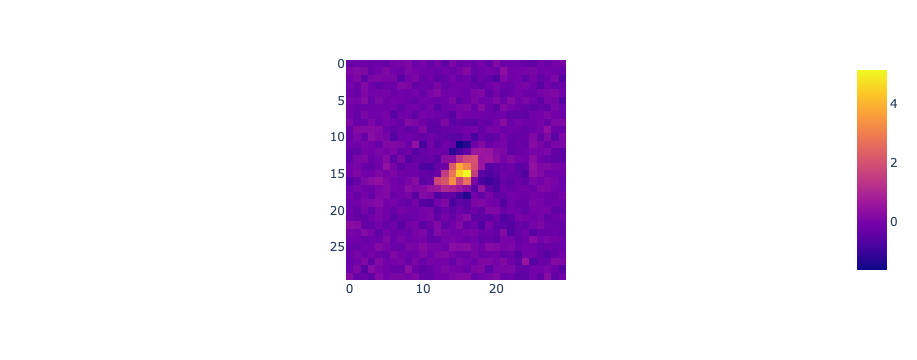

5.163359369814252


In [155]:
residuals = star_cutout - model(best_fit.x, oversampled_psf, 10, star_cutout.shape)
px.imshow(residuals, aspect='equal').show()
print(np.max(residuals))

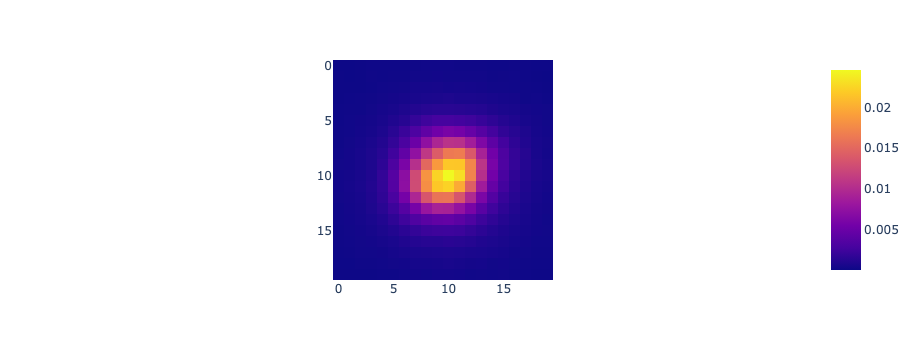

In [117]:
px.imshow(m.evaluate(x_center, y_center), aspect='equal').show()

In [53]:
np.sum(star_cutout)

1071.3467

In [16]:
import numpy as np
np.argmax(m.evaluate(x_center, y_center))

210

In [20]:
m.evaluate(2050.4, 2052.2).sum()

1.0

In [66]:
s = slice(0, 100, 1)

In [70]:
s.indices(105)

(0, 100, 1)